In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as graph
import seaborn as sns

from rosey.helpers import vec_to_array

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
import keras.losses as klosses
import keras.optimizers as kopt
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# %env KERAS_BACKEND=theano
# %env THEANO_FLAGS=device=cuda3,floatX=float32,optimizer=fast_run

graph.style.use('fivethirtyeight')

def plot_number(xi, yi=''):
    graph.figure(figsize=(1, 1))
    graph.title('{}'.format(yi))
    graph.imshow(xi.reshape(28, 28), cmap='Greys')
    graph.xticks([])
    graph.yticks([])
    graph.grid(False)
    graph.show()

/home/stephen/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data
df = pd.read_csv('data/digit-recognizer/train.csv')

y = df.pop('label')
x = df.values
x = MinMaxScaler().fit_transform(x)
print(y.shape, x.shape)

y_train, y_test, x_train, x_test = train_test_split(y, x, test_size=0.25)
_ = [print(a.shape) for a in (y_train, y_test, x_train, x_test)]

/home/stephen/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(42000,) (42000, 784)
(31500,)
(10500,)
(31500, 784)
(10500, 784)


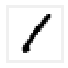

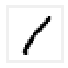

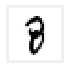

In [3]:
plot_number(x[0, :])
plot_number(x[39370, :])
plot_number(x[17521, :])

# Simple Autoencoder

In [4]:
# Simple Autoencoder
input_layer = Input(shape=(x.shape[1],))

encoder_layer = Dense(100, activation='elu')(input_layer)  # Bottleneck

output_layer = Dense(x.shape[1], activation='sigmoid')(encoder_layer)

# Create models
autoencoder = Model(input_layer, output_layer)
encoder = Model(input_layer, encoder_layer)

display(autoencoder.summary())

# Compile
autoencoder.compile(
    loss=klosses.binary_crossentropy,
    optimizer=kopt.RMSprop(),
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               79184     
Total params: 157,684
Trainable params: 157,684
Non-trainable params: 0
_________________________________________________________________


None

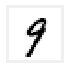

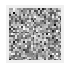

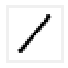

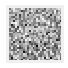

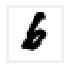

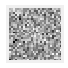

In [5]:
# Before Fitting!
for i in range(3):
    number = vec_to_array(x_train[i, :]).T

    plot_number(number)
    plot_number(autoencoder.predict(number))

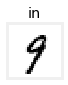

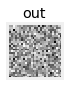

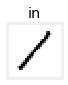

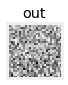

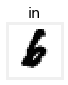

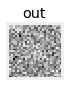

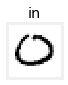

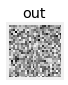

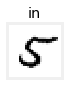

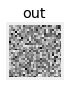

Train on 31500 samples, validate on 10500 samples
Epoch 1/100
31500/31500 [==============================] - 1s 47us/step - loss: 0.5414 - val_loss: 0.3616
Epoch 2/100
31500/31500 [==============================] - 1s 43us/step - loss: 0.3219 - val_loss: 0.2890
Epoch 3/100
31500/31500 [==============================] - 1s 43us/step - loss: 0.2786 - val_loss: 0.2659
Epoch 4/100
31500/31500 [==============================] - 1s 41us/step - loss: 0.2591 - val_loss: 0.2496
Epoch 5/100
31500/31500 [==============================] - 1s 41us/step - loss: 0.2438 - val_loss: 0.2355
Epoch 6/100
31500/31500 [==============================] - 1s 42us/step - loss: 0.2300 - val_loss: 0.2224
Epoch 7/100
31500/31500 [==============================] - 1s 41us/step - loss: 0.2173 - val_loss: 0.2102
Epoch 8/100
31500/31500 [==============================] - 1s 42us/step - loss: 0.2055 - val_loss: 0.1993
Epoch 9/100
31500/31500 [==============================] - 1s 42us/step - loss: 0.1952 - val_loss: 0.1

31500/31500 [==============================] - 1s 42us/step - loss: 0.0902 - val_loss: 0.0906
Epoch 78/100
31500/31500 [==============================] - 1s 42us/step - loss: 0.0900 - val_loss: 0.0903
Epoch 79/100
31500/31500 [==============================] - 1s 42us/step - loss: 0.0897 - val_loss: 0.0901
Epoch 80/100
31500/31500 [==============================] - 1s 42us/step - loss: 0.0895 - val_loss: 0.0896
Epoch 81/100
31500/31500 [==============================] - 1s 41us/step - loss: 0.0892 - val_loss: 0.0898
Epoch 82/100
31500/31500 [==============================] - 1s 42us/step - loss: 0.0891 - val_loss: 0.0892
Epoch 83/100
31500/31500 [==============================] - 1s 41us/step - loss: 0.0887 - val_loss: 0.0891
Epoch 84/100
31500/31500 [==============================] - 1s 42us/step - loss: 0.0886 - val_loss: 0.0888
Epoch 85/100
31500/31500 [==============================] - 1s 41us/step - loss: 0.0884 - val_loss: 0.0886
Epoch 86/100
31500/31500 [========================

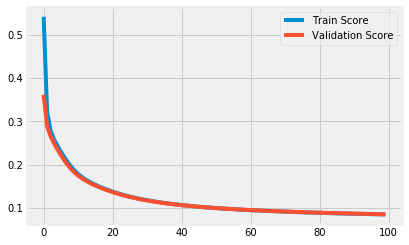

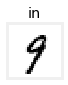

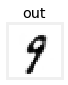

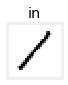

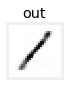

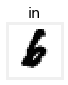

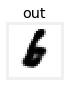

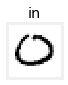

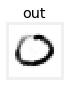

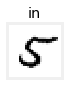

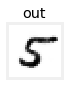

Train on 31500 samples, validate on 10500 samples
Epoch 1/100
31500/31500 [==============================] - 1s 41us/step - loss: 0.0853 - val_loss: 0.0858
Epoch 2/100
31500/31500 [==============================] - 1s 42us/step - loss: 0.0853 - val_loss: 0.0854
Epoch 3/100
31500/31500 [==============================] - 1s 41us/step - loss: 0.0850 - val_loss: 0.0855
Epoch 4/100
31500/31500 [==============================] - 1s 41us/step - loss: 0.0849 - val_loss: 0.0852
Epoch 5/100
31500/31500 [==============================] - 1s 42us/step - loss: 0.0848 - val_loss: 0.0852
Epoch 6/100
31500/31500 [==============================] - 1s 41us/step - loss: 0.0846 - val_loss: 0.0850
Epoch 7/100
31500/31500 [==============================] - 1s 41us/step - loss: 0.0845 - val_loss: 0.0849
Epoch 8/100
31500/31500 [==============================] - 1s 41us/step - loss: 0.0843 - val_loss: 0.0847
Epoch 9/100
31500/31500 [==============================] - 1s 41us/step - loss: 0.0843 - val_loss: 0.0

31500/31500 [==============================] - 1s 40us/step - loss: 0.0788 - val_loss: 0.0793
Epoch 78/100
31500/31500 [==============================] - 1s 39us/step - loss: 0.0787 - val_loss: 0.0793
Epoch 79/100
31500/31500 [==============================] - 1s 40us/step - loss: 0.0786 - val_loss: 0.0792
Epoch 80/100
31500/31500 [==============================] - 1s 40us/step - loss: 0.0785 - val_loss: 0.0793
Epoch 81/100
31500/31500 [==============================] - 1s 44us/step - loss: 0.0786 - val_loss: 0.0790
Epoch 82/100
31500/31500 [==============================] - 1s 41us/step - loss: 0.0785 - val_loss: 0.0793
Epoch 83/100
31500/31500 [==============================] - 1s 42us/step - loss: 0.0784 - val_loss: 0.0790
Epoch 84/100
31500/31500 [==============================] - 1s 41us/step - loss: 0.0785 - val_loss: 0.0793
Epoch 85/100
31500/31500 [==============================] - 1s 45us/step - loss: 0.0783 - val_loss: 0.0787
Epoch 86/100
31500/31500 [========================

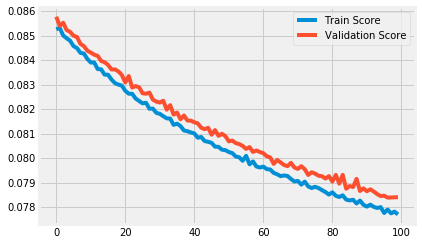

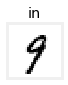

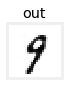

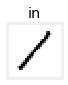

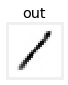

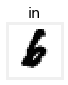

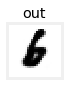

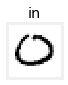

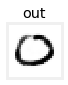

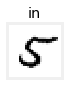

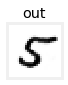

Train on 31500 samples, validate on 10500 samples
Epoch 1/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0777 - val_loss: 0.0783
Epoch 2/100
31500/31500 [==============================] - 1s 37us/step - loss: 0.0776 - val_loss: 0.0781
Epoch 3/100
31500/31500 [==============================] - 1s 37us/step - loss: 0.0776 - val_loss: 0.0781
Epoch 4/100
31500/31500 [==============================] - 1s 37us/step - loss: 0.0775 - val_loss: 0.0782
Epoch 5/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0776 - val_loss: 0.0783
Epoch 6/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0774 - val_loss: 0.0782
Epoch 7/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0774 - val_loss: 0.0780
Epoch 8/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0774 - val_loss: 0.0781
Epoch 9/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0773 - val_loss: 0.0

31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 73/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 74/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 75/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758

Epoch 00075: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 76/100
31500/31500 [==============================] - 1s 39us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 77/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 78/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 79/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 80/100
31500/31500 [==============================] - 1s 38us/step - l

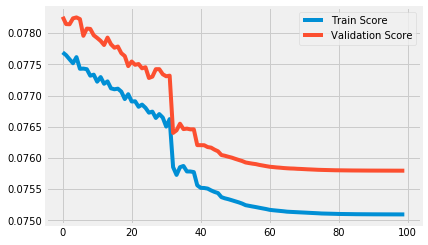

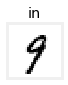

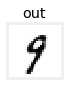

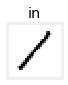

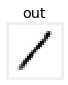

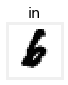

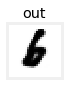

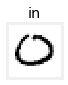

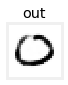

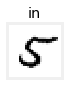

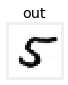

Train on 31500 samples, validate on 10500 samples
Epoch 1/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 2/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 3/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 4/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 5/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 6/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 7/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 8/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 9/100
31500/31500 [==============================] - 1s 37us/step - loss: 0.0751 - val_loss: 0.0

31500/31500 [==============================] - 1s 37us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 78/100
31500/31500 [==============================] - 1s 36us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 79/100
31500/31500 [==============================] - 1s 36us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 80/100
31500/31500 [==============================] - 1s 37us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 81/100
31500/31500 [==============================] - 1s 39us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 82/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 83/100
31500/31500 [==============================] - 1s 37us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 84/100
31500/31500 [==============================] - 1s 37us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 85/100
31500/31500 [==============================] - 1s 36us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 86/100
31500/31500 [========================

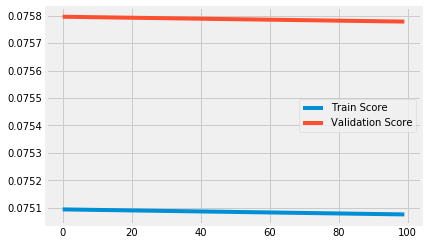

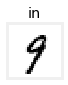

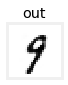

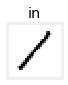

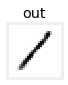

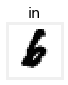

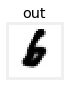

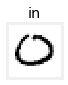

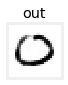

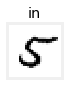

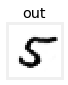

Train on 31500 samples, validate on 10500 samples
Epoch 1/100
31500/31500 [==============================] - 1s 39us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 2/100
31500/31500 [==============================] - 1s 39us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 3/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 4/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 5/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 6/100
31500/31500 [==============================] - 1s 38us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 7/100
31500/31500 [==============================] - 1s 40us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 8/100
31500/31500 [==============================] - 1s 40us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 9/100
31500/31500 [==============================] - 1s 39us/step - loss: 0.0751 - val_loss: 0.0

31500/31500 [==============================] - 1s 39us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 78/100
31500/31500 [==============================] - 1s 39us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 79/100
31500/31500 [==============================] - 1s 39us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 80/100
31500/31500 [==============================] - 1s 40us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 81/100
31500/31500 [==============================] - 1s 40us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 82/100
31500/31500 [==============================] - 1s 39us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 83/100
31500/31500 [==============================] - 1s 39us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 84/100
31500/31500 [==============================] - 1s 41us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 85/100
31500/31500 [==============================] - 1s 39us/step - loss: 0.0751 - val_loss: 0.0758
Epoch 86/100
31500/31500 [========================

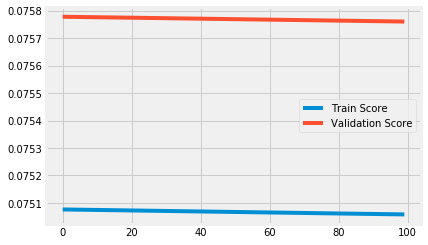

CPU times: user 44min 41s, sys: 8min 37s, total: 53min 18s
Wall time: 10min 30s


In [6]:
%%time
# Fit model! (n*100) epochs
for _ in range(5):
    # Check fit
    for i_img in range(5):
        number_i = vec_to_array(x_train[i_img, :]).T
        
        plot_number(number_i, 'in')
        plot_number(autoencoder.predict(number_i), 'out')
    
    # Train
    hist = autoencoder.fit(
        x_train, x_train,
        epochs=100, validation_data=(x_test, x_test), batch_size=4096,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=15),
            ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6, verbose=1),
            ModelCheckpoint('data/model.ckp', monitor='val_loss', save_best_only=True)
        ],
        shuffle=True
    )
    
    # Summary of performance
    graph.plot(hist.history['loss'], label='Train Score')
    graph.plot(hist.history['val_loss'], label='Validation Score')
    graph.legend()
    graph.show()

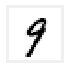

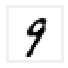

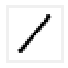

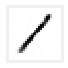

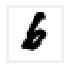

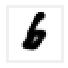

In [8]:
# After Fitting!
for i in range(3):
    number = vec_to_array(x_train[i, :]).T

    plot_number(number)
    plot_number(autoencoder.predict(number))

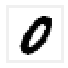

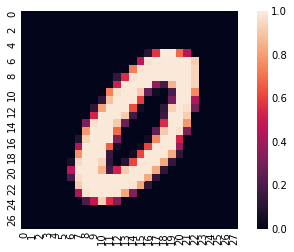

Representation


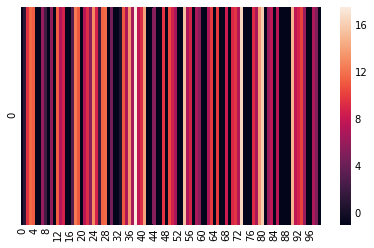

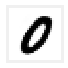

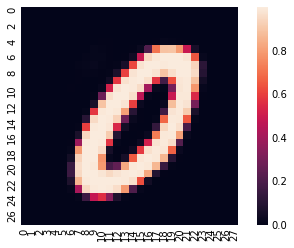

In [9]:
new_number = vec_to_array(x_test[1013, :]).T

plot_number(new_number)

sns.heatmap(new_number.reshape((28, 28)), square=True)
graph.show()

print('Representation')
sns.heatmap(encoder.predict(new_number))
graph.show()

print('')
plot_number(autoencoder.predict(new_number))

sns.heatmap(autoencoder.predict(new_number).reshape((28, 28)), square=True)
graph.show()

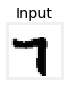

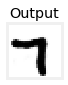

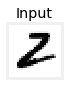

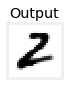

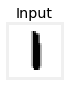

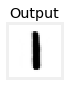

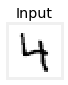

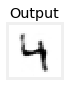

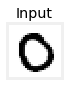

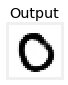

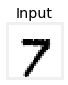

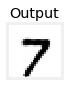

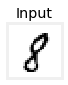

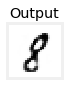

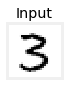

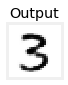

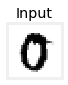

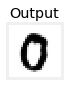

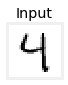

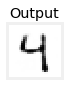

In [10]:
# Test set fits!
for i in range(10):
    number = vec_to_array(x_test[i, :]).T

    plot_number(number, 'Input')
    plot_number(autoencoder.predict(number), 'Output')